In [2]:
import numpy as np

import pandas as pd
pd.options.display.max_colwidth = None

import nltk
# скачиваем один раз
# nltk.download('stopwords')
# nltk.download('punkt')

import pymorphy2

from gensim.models import Word2Vec


In [3]:
import seaborn
seaborn.set_style('whitegrid')

In [4]:
# загружаем датасет с отзывами
reviews = pd.read_csv('dataset.csv')
reviews = reviews.loc[:100000]
reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   userName      100000 non-null  object
 1   content       100001 non-null  object
 2   replyContent  96344 non-null   object
 3   score         100001 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [5]:
# предобрабатываем данные

from nltk.corpus import stopwords
rus_stopwords = stopwords.words("russian")

morph = pymorphy2.MorphAnalyzer()

content = reviews['content']

print(content.loc[0:15])

content = content.apply(lambda sentence: nltk.word_tokenize(sentence.lower(), language="russian"))
content = content.apply(lambda tokens: list(token for token in tokens if token.isalpha()))
content = content.apply(lambda tokens: list(morph.parse(token)[0].normal_form for token in tokens))
content = content.apply(lambda tokens: list(token for token in tokens if token not in rus_stopwords))

print(content.loc[0:15])

reviews['content'] = content


0     Предлагает банк категории повышеного кэшбека которыми я не пользуюсь. Постоянный Кэшбек 1% банк отменил. Как всегда все для удобства пользователей. Чтоб его выбрать теперь надо напоминание едемесячное на телефоне настраивать.
1                                                                                                                                                                                                                              Суперрр!
2                                                                                                                                                                                          Ужасныйе поведение сотрудника. Я не доволен.
3                                                                                                                                                                                                    Норм тема , там ещё 18* карты есть
4                                                                       

In [6]:
# удаляем пустые строки
reviews = reviews[reviews['content'].apply(lambda l: len(l) > 0)]
reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 95738 entries, 0 to 100000
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userName      95737 non-null  object
 1   content       95738 non-null  object
 2   replyContent  92211 non-null  object
 3   score         95738 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.7+ MB


In [7]:
%%time
# обучаем Word2Vec на наших данных
import multiprocessing
cores = multiprocessing.cpu_count()
print(f'Ядер: {cores}')

model = Word2Vec(reviews['content'],
                  min_count=5,
                  window=5,
                  vector_size=100,
                  sample=1e-3,
                  alpha=0.025,
                  min_alpha=0.0001,
                  negative=5,
                  workers=cores-1,
                  epochs=5)

print(f'Размер словаря: {len(model.wv.vectors)}')


Ядер: 8
Размер словаря: 5418
CPU times: total: 8.38 s
Wall time: 2.73 s


In [8]:
X = []
map = {}
for (i, tokens) in reviews['content'].iteritems():
    vecs = []
    for token in tokens:
        if model.wv.has_index_for(token):
            vecs.append(model.wv.get_vector(token))
    if vecs:
        vec_avg = np.asarray(vecs).mean(axis=0)
        X.append(vec_avg)
        map[len(X) - 1] = i

print(f'Векторов предложений: {len(X)}')


C:\Users\levpo\AppData\Local\Temp\ipykernel_15564\1617619978.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (i, tokens) in reviews['content'].iteritems():


Векторов предложений: 94717


In [9]:
from MyCMeans import MyCMeans

In [10]:
cmeans = MyCMeans(n_clusters=9, w=1.1, max_iter=1000)


In [11]:
%%time
# сначала проверим на оригинальных данных
cmeans.fit(X)
print(cmeans.centers_)


total: 109 iters
[[-4.09366485e-01  1.36897610e-01  3.35335039e-01  3.66802840e-02
   2.72351167e-01 -9.92572404e-01  2.74627106e-01  9.83129639e-01
   1.70409866e-01 -9.17034333e-01 -4.75649544e-02 -3.06351503e-01
  -2.04834033e-01  1.65805117e-01 -6.55981809e-02 -4.36858135e-01
   4.60890932e-01 -2.51009418e-01  3.04885527e-03 -8.21385187e-01
  -2.41682046e-01  1.18379101e-01  9.44038578e-02 -3.25700280e-01
  -8.38783915e-02  2.48995389e-02 -8.30069096e-01 -1.80840740e-01
   1.54692592e-01  3.00926344e-01  3.04393432e-01  3.13594707e-01
   2.26359892e-01 -4.65800976e-01 -1.36085122e-01  3.15223167e-01
  -8.56934061e-02 -5.24561460e-01  7.42525708e-02 -4.60790347e-01
   2.96581795e-01 -7.05558737e-01  3.77364697e-01 -5.34085273e-02
   9.93827640e-02 -5.29842797e-01  1.43205425e-01 -1.84879842e-01
   1.35998645e-01  1.50399068e-01  5.50216719e-01  1.43550499e-01
   4.04119492e-01 -5.00589585e-02 -5.48831780e-02  2.87340998e-01
   1.87837764e-01  6.86904190e-01  3.14712585e-01  7.020290

In [12]:
for c in range(cmeans.k):
    nearest5 = np.argsort(np.linalg.norm(X - cmeans.centers_[c], axis=1))[:5]
    for i in nearest5:
        print(reviews['content'][map.get(i)], np.linalg.norm(X[i] - cmeans.centers_[c]))
    print()


['около', 'отлично'] 1.049568510846082
['отлично', 'тупить', 'норма'] 1.0759609842848858
['принцип', 'нормально', 'устраивать'] 1.158499227311486
['отлично', 'начало'] 1.2364780384493697
['гуд', 'пока', 'устраивать', 'отлично'] 1.2422641576507094

['хороший', 'российский', 'банк', 'идеальный'] 0.6065093137750722
['правда', 'хороший', 'банк', 'рф', 'хороший'] 0.7507559972718207
['любимый', 'родный', 'самый', 'хороший', 'банк', 'планета'] 0.7555461086632835
['реально', 'хороший', 'онлайн', 'банк'] 0.7605406341328083
['самый', 'хороший', 'крутой', 'банк', 'остальной', 'банк', 'курить', 'сторонка'] 0.7627058584057373

['всё', 'гуд'] 0.736806636730051
['всё', 'гуд'] 0.736806636730051
['всё', 'гуд'] 0.736806636730051
['всё', 'гуд'] 0.736806636730051
['всё', 'гуд'] 0.736806636730051

['очень', 'удобный', 'функциональный', 'приложение', 'хороший', 'приложение', 'инвестиция'] 0.7232574188179508
['очень', 'удобный', 'приложение', 'шикарный', 'приложение'] 0.8260700925612056
['хороший', 'достаточ

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [14]:
%%time
# найдем оценку для оригинальных данных
print(silhouette_score(X, cmeans.labels_))


0.17083097
CPU times: total: 10min 18s
Wall time: 4min 40s


In [15]:
# уменьшаем размерность векторов
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, random_state=42)
X_svd = svd.fit_transform(X)

print(X_svd.shape)

(94717, 20)


In [16]:
%%time
# теперь проверим на данных пониженной размерности
cmeans.fit(X_svd)
print(cmeans.centers_)


total: 107 iters
[[ 2.75631908e+00 -1.84606010e+00  3.01655146e-01  9.85766762e-02
  -8.39307377e-01  5.03834076e-01 -6.79596189e-01 -8.27874790e-03
  -1.05545120e-01 -5.06485196e-03 -9.84529339e-02  6.75187774e-02
   3.29958112e-02 -6.91649762e-02 -3.49827057e-03  5.14042242e-02
   3.91548683e-02 -6.73045612e-02 -4.08675017e-02 -2.28999278e-02]
 [ 2.47309206e+00  2.24451488e+00 -6.76615871e-01  8.39989465e-01
  -4.80216099e-01  1.49223586e-01 -3.17562875e-01  4.46741400e-01
  -6.72810088e-03  1.99618179e-01 -8.49833915e-02 -6.59627191e-02
   1.09421891e-01  9.37939787e-02 -1.39495796e-01 -5.83690160e-02
  -1.83169178e-02 -7.09365695e-02  3.45138856e-03 -4.24830943e-02]
 [ 3.75213222e+00 -1.87340457e+00 -8.23024455e-01  3.45114460e-01
   1.54781443e+00  2.76386884e-01  2.68217631e-01  6.53021650e-01
   5.49619845e-01 -9.06632047e-02 -5.21581480e-02 -1.44695576e-01
  -4.29773036e-02  1.80069764e-01 -1.24572644e-01 -1.17359626e-01
  -1.27211998e-01  1.21279897e-01  1.17304685e-01 -1.7611

In [17]:
for c in range(cmeans.k):
    nearest5 = np.argsort(np.linalg.norm(X_svd - cmeans.centers_[c], axis=1))[:5]
    for i in nearest5:
        print(reviews['content'][map.get(i)], np.linalg.norm(X_svd[i] - cmeans.centers_[c]))
    print()


['всё', 'устраивать', 'всё', 'доступно', 'понимание'] 0.6241867686480471
['всё', 'гуд'] 0.6906670916830512
['всё', 'гуд'] 0.6906670916830512
['всё', 'гуд'] 0.6906670916830512
['всё', 'гуд'] 0.6906670916830512

['хороший', 'российский', 'банк', 'идеальный'] 0.5731144184969774
['любимый', 'родный', 'самый', 'хороший', 'банк', 'планета'] 0.6505895607102252
['реально', 'хороший', 'онлайн', 'банк'] 0.6674215145856758
['удобство', 'весь', 'хороший', 'онлайн', 'банк'] 0.6764257180667568
['правда', 'хороший', 'банк', 'рф', 'хороший'] 0.6977725673942768

['удобно', 'доступно', 'комфортно'] 0.8167779873974415
['удобно', 'доступно', 'практично'] 0.8206993784125429
['доступно', 'практично', 'удобно'] 0.8206994188778498
['удобно', 'практично', 'доступно'] 0.8206994493692077
['удобно', 'практично'] 0.8236854956652483

['супер', 'восторг'] 0.8088129113349191
['супер', 'удобно', 'супер', 'комфортно', 'супер', 'современно', 'строго', 'рекомендовать'] 0.8832707780968169
['супер', 'благодарить'] 0.896382

In [18]:
%%time
# найдем оценку для данных пониженной размерности
print(silhouette_score(X, cmeans.labels_))


0.17068061
CPU times: total: 10min 4s
Wall time: 4min 15s


Как видим, если данные высокой размерности, то можно понизить размерность выиграв в качестве.

In [19]:
from sklearn.cluster import KMeans

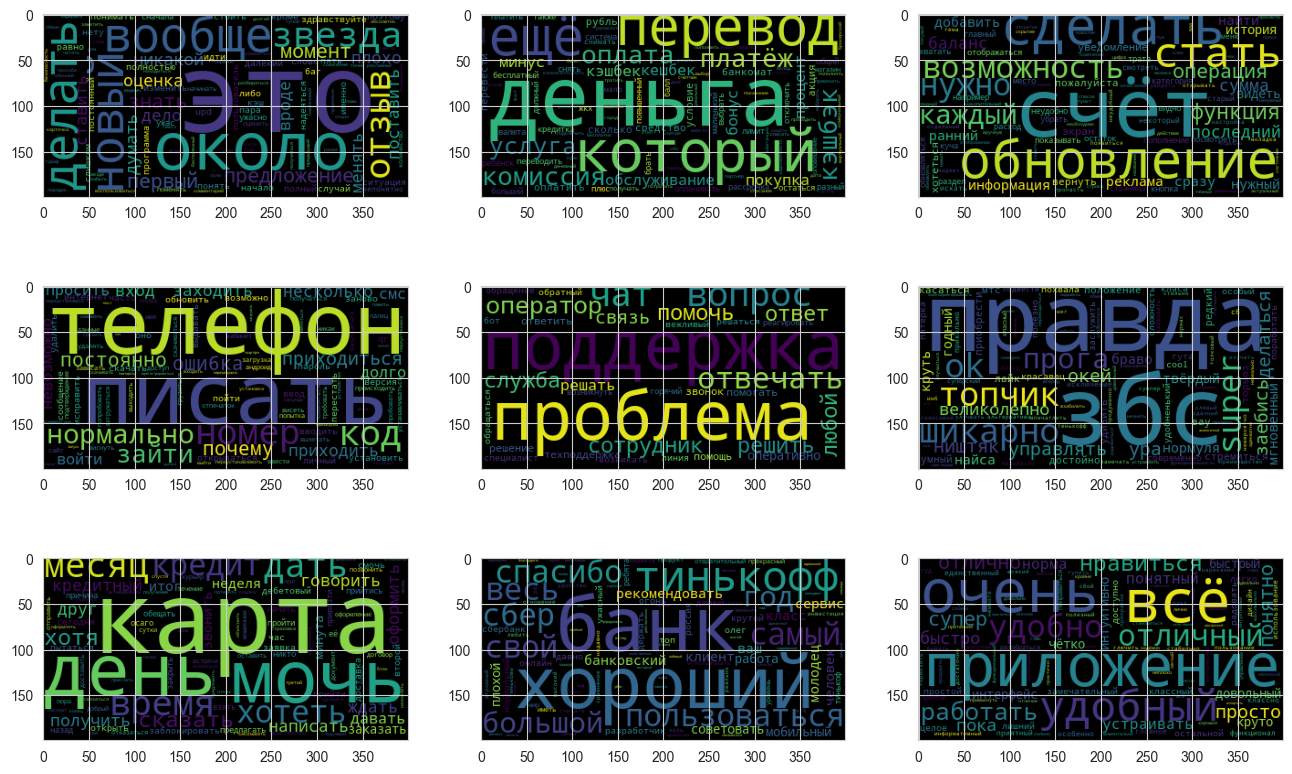

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def draw_wordcloud(words, max_words=100, width=400, height=200):
    wordcloud = WordCloud(max_words=max_words, width=width, height=height)
    text = ' '.join(words)
    if text == '':
        text = 'None'
    wordcloud.generate(text)
    return wordcloud.to_image()

X = model.wv.vectors
X_svd = svd.fit_transform(X)
k = 9
# cmeans = MyCMeans(n_clusters=k, w=1.1)
# cmeans.fit(X_svd)
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_svd)

df = pd.DataFrame()
df['corpus'] = model.wv.index_to_key
df['cluster'] = kmeans.labels_

images = [draw_wordcloud(df[df['cluster'] == i]['corpus']) for i in range(k)]

fig, ax = plt.subplots(3, 3, figsize=(16, 10))
for i in range(k):
    ax[i // 3, i % 3].imshow(images[i])
plt.show()


total: 1249 iters
total: 28 iters
total: 36 iters
total: 34 iters
total: 16 iters
total: 120 iters


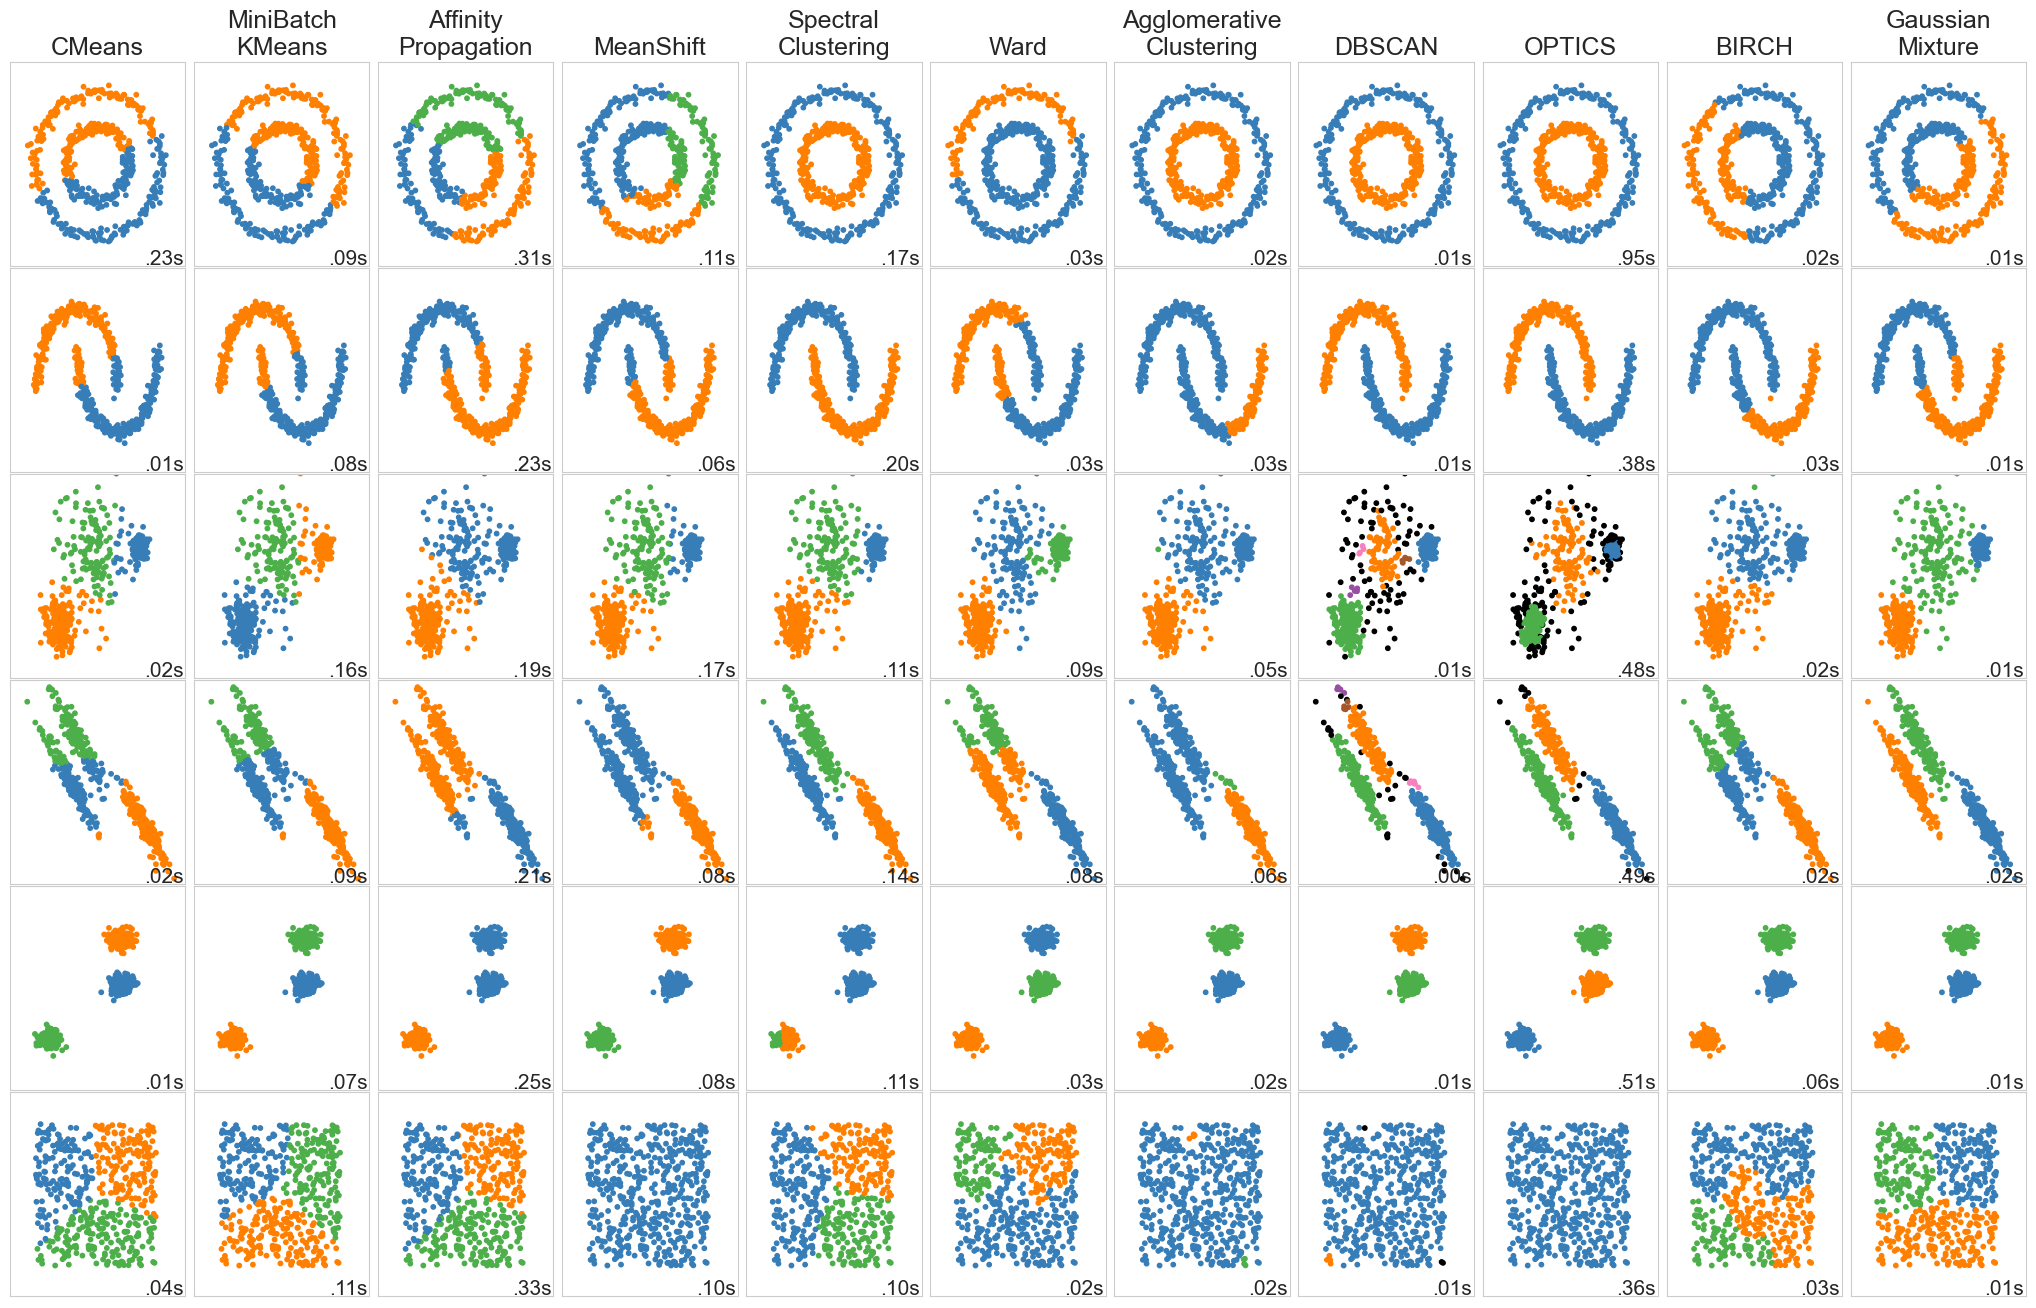

In [24]:
# Сравнение c-means с другими алгоритмами. Как видим, на этих датасетах он ведет себя примерно также, как k-means

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from MyCMeans import MyCMeans

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    cmeans = MyCMeans(n_clusters=params["n_clusters"], w=3.0, max_iter=10000)
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("CMeans", cmeans),
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),

    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

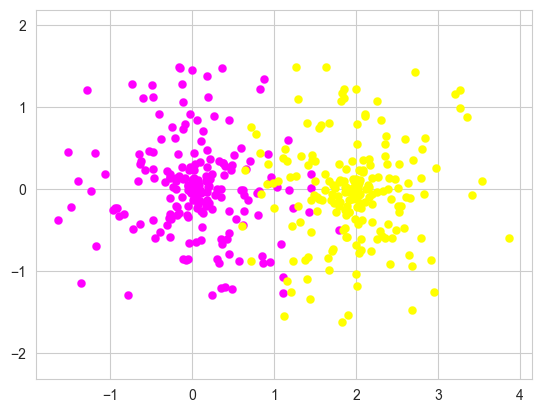

In [26]:
# Теперь рассмотрим пример, где c-means будет работать лучше, чем k-means.
# Создадим 2 пересекающихся множества в виде кругов Эйлера

from math import *
import random
import matplotlib.pyplot as plt

random.seed(42)

def get_x(p):
    return 1 - sqrt(1 - p)

def generate_set(n, x0, y0, r):
    set = []
    for i in range(n):
        phi = random.random() * pi * 2
        l = get_x(random.random()) * r
        x = x0 + cos(phi) * l
        y = y0 + sin(phi) * l
        set.append((x, y))
    return set

r = 2
x1 = 0
y1 = 0
x2 = 2
y2 = 0
n1 = 200
n2 = 200
set1 = np.array(generate_set(n1, x1, y1, r))
set2 = np.array(generate_set(n2, x2, y2, r))

plt.axis('equal')
plt.scatter(set1[:, [0]], set1[:, [1]], c='magenta', linewidths=0.1)
plt.scatter(set2[:, [0]], set2[:, [1]], c='yellow', linewidths=0.1)


In [27]:
X = np.concatenate((set1, set2), axis=0)
np.random.shuffle(X)


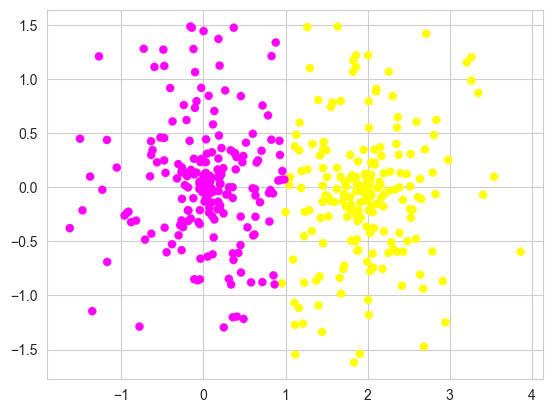

In [28]:
# Запустим кластеризацию k-means. Видно, что граница четкая

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plt.scatter(X[:, [0]], X[:, [1]], c=kmeans.labels_, cmap='spring', linewidths=0.1)


total: 13 iters


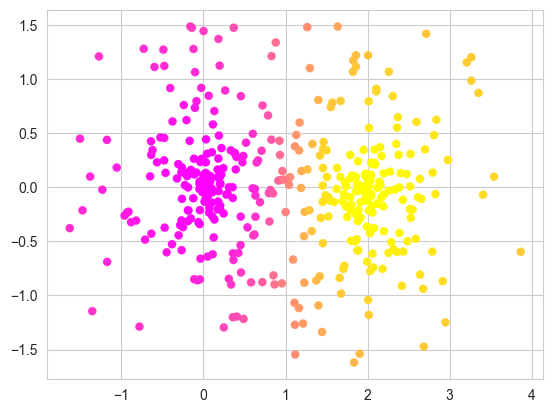

In [29]:
cmeans = MyCMeans(n_clusters=2, w=2.0)
cmeans.fit(X)

plt.scatter(X[:, [0]], X[:, [1]], c=cmeans.M_[:, [0]], cmap='spring', linewidths=0.1)


total: 19 iters


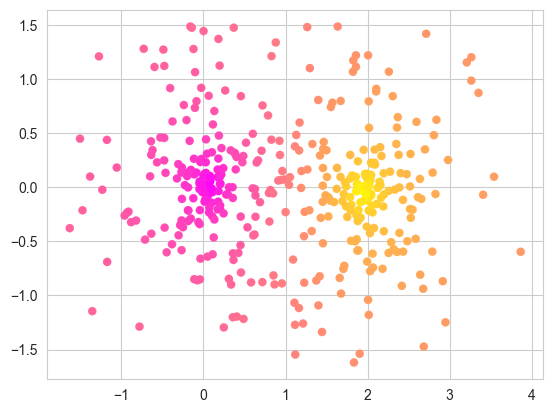

In [30]:
cmeans = MyCMeans(n_clusters=2, w=5)
cmeans.fit(X)

plt.scatter(X[:, [0]], X[:, [1]], c=cmeans.M_[:, [0]], cmap='spring', linewidths=0.1)


## Functions

### Distance
Евклидово расстояние:

Точки p and q в пространстве.
$$
d(p,q) = \sqrt{\sum_{i=1}^n (q_i - p_i)^2 }
$$

### Update Membership Values
Uses following formula:

$$
u_{ik} = \frac{\left(\frac{1}{ X_k - V_i }\right)^{\frac{2}{m-1}}}{\sum_{j=0}^c \left(\frac{1}{ X_k - V_j }\right)^{\frac{2}{m-1}}}
$$


$u_{ik}$ is membership value of k-th data to i-th cluster:

$V_i$ is center of i-th cluster

$X_i$ is i-th data point

$m$ is fuzziness

$N$ is number of data points

###  Update Clusters Center
Uses following formula:

$$
V_{i} = \frac{\sum_{k=1}^{N} u_{ik}^m X_k}{\sum_{k=1}^{N} u_{ik}^m}
$$


$u_{ik}$ is membership value of k-th data to i-th cluster:

$V_i$ is center of i-th cluster

$X_k$ is k-th data point

$m$ is fuzziness

$N$ is number of data points

### Cost Funcion
Uses following formula:

$$
J = \sum_{j=1}^{N} \sum_{i=1}^{c} u_{ij}^m  X_j - V_i ^2
$$


$u_{ij}$ is membership value of j-th data to i-th cluster:

$V_i$ is center of i-th cluster

$X_j$ is j-th data point

$m$ is fuzziness

$N$ is number of data points

### Defuzzification
Uses maximum membership value for crisp clustering.



### Analysis

$$
Cost = \sum_{j=1}^{N} \sum_{i=1}^{c} u_{ij}^m  X_j - V_i ^2
$$


Here, because the m is between 0 and 1 so the more value for m gives less value for $u_{jk}^m$ and this reduces cost function value.

In this particular case beacase of following reasons, $m$ value hasn't much effect on clustering:

1. Clusters are far from each other.
1. Clusters are symmetical.

Actually if we use KNN instead of FCM, we will get the same result.

If we consider effect of $m$ on fuzzy clustering, we can say "higher value for $m$ makes the membership values  become closer to each other." (Softer)